In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Load COVID-19 data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# datapath = "/content/drive/MyDrive/covidDataset/dataset"
datapath = "../input/coviddataset-nosplit/covidDataset" # kaggle


import pathlib
def get_imagepath_and_labels(datapath):
    data_root = pathlib.Path(datapath)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]

    all_image_label = [pathlib.Path(single_image_path).parent.name for single_image_path in all_image_path]

    return all_image_path, all_image_label

all_image_path, all_image_label = get_imagepath_and_labels(datapath)
print(len(all_image_path))
print(len(all_image_label))

2481
2481


In [4]:
# images = all_image_path[:10]+all_image_path[2471:]
# labels = all_image_label[:10]+all_image_label[2471:]

In [5]:
import numpy as np
import cv2

def get_images_and_labels_astensor(image_path, image_labels, channels):
    images = []
    labels = []
    for i in range(0, len(image_path)):
        image = image_astensor(image_path[i], channels=channels)
        images.append(image)
        labels.append(image_labels[i])
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def image_astensor(image_path, channels):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (180, 180), interpolation= cv2.INTER_LINEAR)
        image = np.array(image).astype('float32')
        image = image / 255

        return image

start_time = time.time()
images, labels = get_images_and_labels_astensor(all_image_path, all_image_label, channels=1)
# images, labels = get_images_and_labels_astensor(images, labels, channels=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 33.5189573764801 seconds ---


In [6]:
print(np.unique(labels, return_counts=True))

(array(['COVID', 'non-COVID'], dtype='<U9'), array([1252, 1229]))


(180, 180)
0.21568628
1.0
float32


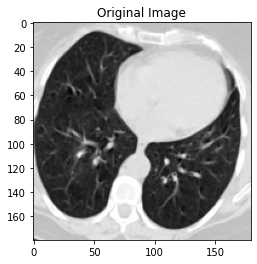

In [7]:
print(np.shape(images[1]))
print(np.amin(images[1]))
print(np.amax(images[1]))
print(images[1].dtype)

plt.imshow(images[1], cmap='gray')
plt.title("Original Image")
plt.show()

In [8]:
import pywt
from matplotlib import pyplot as plt

In [9]:
 def decompose_images(images):
    decomposed_images = []
    for i in images:
      a, b ,c, d = get_coeffs(i)
      e, f, g, h = get_coeffs(a)
#       j, k, l, m = get_coeffs(e)
#       decomposed_images.append([ b, c, d, f, g, h, k, l, m])
      decomposed_images.append([ b, c, d, f, g, h])
    return decomposed_images

def get_coeffs(image):
    coeffs = pywt.dwt2(image,'bior4.4', mode='periodization', axes=(-2, -1))
    cA, (cH, cV, cD) = coeffs
    return cA, cH, cV, cD

In [10]:
start_time = time.time()
d_images = decompose_images(images)
print("--- %s seconds ---" % (time.time() - start_time))

d_images = np.array(d_images, dtype=object)
print(d_images.shape)

--- 4.189426898956299 seconds ---
(2481, 6)


In [11]:
print(d_images.shape[0])
print(d_images.shape[1])

2481
6


In [12]:
# %run /content/drive/MyDrive/WT-GLCM-NN/haralick_feature_test/haralick_features_V1.03.py
%run ../input/haralickfeaturespy/haralick_features_V1.03.py #kaggle

<Figure size 432x288 with 0 Axes>

In [13]:
# from skimage.feature import greycomatrix
from skimage.feature import graycomatrix #kaggle
def extract_features(d_images):
    feature_vector = []
    for i in range(d_images.shape[0]):
        feature = []
        for j in range(d_images.shape[1]):
            image = d_images[i, j].astype(np.uint8)
            g = get_glcm(image)
            for p in range(g.shape[2]):
                for k in range(g.shape[3]):
                    feature.append(glcm_features(g[:, :, p, k].reshape(256, 256, 1, 1)))
        feature_vector.append(feature)
    return feature_vector

def glcm_features(glcm):
    features = get_haralick_features(glcm)
    return features

def get_glcm(image):
    distances = [1, 2]
    # distances = [2, 3]
    # angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4]
    # angles = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
#     glcm = greycomatrix(image, distances, angles, levels = 256)
    glcm = graycomatrix(image, distances, angles, levels = 256)
    return glcm

In [14]:
def find_min_max(im):
    MAX = 0
    MIN = 0
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if MAX < np.amax(im[i][j]):
                MAX = np.amax(im[i][j])
            else: pass
            if MIN > np.amin(im[i][j]):
                MIN = np.amin(im[i][j])              
    return [MAX, MIN]

MAX, MIN = find_min_max(d_images) 

In [15]:
print(MAX)
print(MIN)

1.5229372
-1.6244205


In [16]:
d_images = (d_images+ np.abs(MIN) ) * (1 / (np.abs(MIN) + np.abs(MAX)))  * 255
print(d_images[1][4].shape)
print(np.amax(d_images[1][4]))
print(np.amin(d_images[1][4]))

(45, 45)
177.44096
72.85742


In [17]:
start_time = time.time()
group_tensor = extract_features(d_images=d_images)
print("--- %s seconds ---" % (time.time() - start_time))

f_tensor = np.array(group_tensor, dtype=object)
print(f_tensor.shape)

/kaggle/input/haralickfeaturespy/haralick_features_V1.03.py:183: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(maxlist[1])


--- 17110.35839653015 seconds ---
(2481, 48, 15)


reshaping the feature matrix to (1, N)

In [18]:
feature_tensor = f_tensor.reshape(f_tensor.shape[0], -1)
print(feature_tensor.shape)
print(np.amax(feature_tensor))
print(np.amin(feature_tensor))

(2481, 720)
17267.8895359564
[[-0.32243163]]


In [19]:
# file = "/content/drive/MyDrive/WT-GLCM-NN/haralick_feature_test/features-[[01, 02,] 4].csv"
file = "/kaggle/working/features-[[01, 02,] 4].csv" #kaggle
np.savetxt(file, feature_tensor, delimiter=",")

Scikit learn deal with Nan values : [reference](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

In [20]:
# file = "/content/drive/MyDrive/WT-GLCM-NN/haralick_feature_test/featuresWithMaxCorrCoeff2.csv"
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = pd.read_csv(file, sep=",")
print(df.isna().sum().sum())
if df.isna().sum().sum() != 0:
    imp = IterativeImputer(max_iter=20, random_state=42)
    imp.fit(feature_tensor)
    tensor = imp.transform(feature_tensor)
    # file = "/content/drive/MyDrive/WT-GLCM-NN/haralick_feature_test/features-[[01, 02,] 4]-NoNan.csv"
    file = "/kaggle/working/features-[[01, 02,] 4-NoNan].csv" #kaggle
    np.savetxt(file, tensor, delimiter=",")
    df = pd.read_csv(file, sep=",")
    print("Nan Counts: ",df.isna().sum().sum())
else:
    tensor = feature_tensor

1304
Nan Counts:  0


In [21]:
print(tensor.shape)
print(type(tensor))
print(np.amax(tensor))
print(np.amin(tensor))

(2481, 720)
<class 'numpy.ndarray'>
17635.223754331335
-0.6462626804042385


## Feature Selection

In [22]:
import scipy.stats as stats

In [23]:
def get_p_value(data1, data2):
    _, p_value = stats.ttest_ind(a = data1, b=data2)
    return p_value


def twosample_ttest(population):
    x = []
    for i in range(population.shape[1]):
        y = []
        for j in range(population.shape[1]):
            p_val = get_p_value( population[0:, i], population[0:, j])
            y.append(p_val)
        x.append(y)
    return x

p_value_stat = twosample_ttest(tensor)
p_value_stat = np.array(p_value_stat, dtype=object)
print(p_value_stat.shape)

(720, 720)


In [24]:
p_value_stat[1][5]

0.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


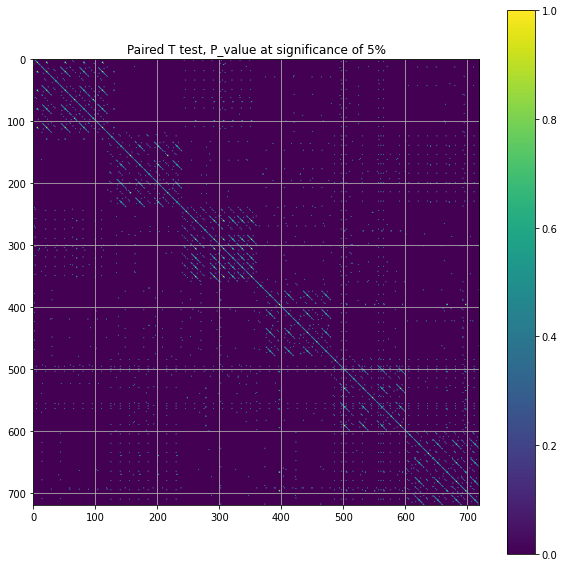

In [25]:
# p_value_stat = np.array(p_value_stat, dtype=np.float64)
mat = np.copy(p_value_stat)
mat[mat > 0.05 ] = 1
mat[mat != 1] = 0 
plt.figure(figsize=(10, 10))
plt.imshow(mat.astype(float))
plt.grid(True)
plt.colorbar()
plt.title("Paired T test, P_value at significance of 5%")
plt.show()

In [26]:
print(np.unique(mat, return_counts=True))

(array([0, 1], dtype=object), array([513686,   4714]))


In [27]:
def feature_selection(mat, tensor):
    indexes = []
    for i in range(mat.shape[1]):
        if np.sum(mat[i, :]) > 2:
            indexes.append(i)
  
    print(len(indexes))
    features = []
    for i in range(len(indexes)):
        features.append(tensor[:, indexes[i]])
    return features

selected_tensor = feature_selection(mat, tensor)
selected_tensor = np.array(selected_tensor)
selected_tensor = np.transpose(selected_tensor)
print(selected_tensor.shape)

543
(2481, 543)


Preparing data







In [28]:
print(np.unique(labels, return_counts=True))

(array(['COVID', 'non-COVID'], dtype='<U9'), array([1252, 1229]))


In [29]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    selected_tensor, 
    labels, 
    test_size=300, 
    shuffle=True,
    random_state=42,
    stratify=labels
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2181, 543)
(2181,)
(300, 543)
(300,)


In [30]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True)) 

(array(['COVID', 'non-COVID'], dtype='<U9'), array([1101, 1080]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([151, 149]))


In [31]:
from sklearn.preprocessing import LabelEncoder
# prepare target

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    # y_valid_enc = le.transform(y_valid)
    return y_train_enc, y_test_enc

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [32]:
print(X_train.shape)
print(X_test.shape)

print(np.amax(X_train))
print(np.amin(X_train))
print(np.amax(X_test))
print(np.amin(X_test))


print(y_train_enc.shape)
print(y_test_enc.shape)

(2181, 543)
(300, 543)
17635.223754331335
-0.44399377097926407
17606.566007219095
-0.41712622543014494
(2181,)
(300,)


In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [34]:
print(X_train.shape)
print(X_test.shape)

print(np.amax(X_train))
print(np.amin(X_train))
print(np.amax(X_test))
print(np.amin(X_test))

(2181, 543)
(300, 543)
19.637817810784398
-7.380221735017483
11.521118243136245
-6.891263293792788


In [35]:
print(np.count_nonzero(np.isnan(X_train)))
print(np.count_nonzero(np.isnan(X_test)))

0
0


In [36]:
print(np.amax(X_train))
print(np.amin(X_train))
print(np.amax(X_test))
print(np.amin(X_test))

19.637817810784398
-7.380221735017483
11.521118243136245
-6.891263293792788


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
max_accuracy = 0


for x in range(1, 50):
    rf = RandomForestClassifier(n_estimators=x)
    rf.fit(X_train,y_train_enc)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,y_test_enc)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

classifier = RandomForestClassifier(n_estimators=best_x, random_state=0)
classifier.fit(X_train, y_train_enc)

RandomForestClassifier(n_estimators=38, random_state=0)

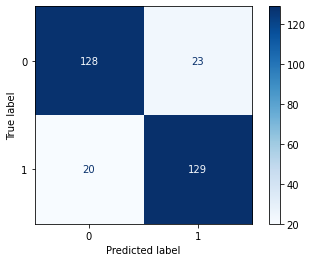

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [39]:
import pandas as pd
from sklearn.metrics import recall_score ,precision_score,accuracy_score, f1_score,roc_auc_score

In [40]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [41]:
binary_classification_performance(y_test_enc,y_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.86,0.85,0.87,0.86,0.86,0.85,0.87,128,129,23,20


In [42]:
import pickle
# save the model to disk
filename = "/kaggle/working/finalized_model.sav"
pickle.dump(classifier, open(filename, 'wb'))

Resources

[Kaggle Example using sklearn classifiers](https://www.kaggle.com/code/jashsheth5/binary-classification-with-sklearn-and-keras-95)

[Introduction to SGD Classifier](https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/)

[Machine Learning Mastery: Save Model](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)
